COLLECTING IMAGES FROM OPENCV

In [1]:
import os 
import time
import uuid
import cv2


In [2]:
images_path=os.path.join('data','images')
number_images=30

In [5]:
cap=cv2.VideoCapture(0)
for imgnum in range(number_images):
    print("collecting image",imgnum)
    ret,frame=cap.read()
    imgname=os.path.join(images_path,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname,frame)
    cv2.imshow('frame',frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF==ord('q'):
        break
cap.release
cv2.destroyAllWindows()

collecting image 0
collecting image 1
collecting image 2
collecting image 3
collecting image 4
collecting image 5
collecting image 6
collecting image 7
collecting image 8
collecting image 9
collecting image 10
collecting image 11
collecting image 12
collecting image 13
collecting image 14
collecting image 15
collecting image 16
collecting image 17
collecting image 18
collecting image 19
collecting image 20
collecting image 21
collecting image 22
collecting image 23
collecting image 24
collecting image 25
collecting image 26
collecting image 27
collecting image 28
collecting image 29


REVIEW DATASET AND BUILD IMAGE LOADING FUNCTION

In [6]:
import tensorflow as tf
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

In [7]:
images=tf.data.Dataset.list_files('data\\images\\*.jpg')


In [8]:
images.as_numpy_iterator().next()

b'data\\images\\d583c16b-7cff-11f0-b09f-dc4ba1005df7.jpg'

In [9]:
def load_image(x):
    byte_img=tf.io.read_file(x)
    img=tf.io.decode_jpeg(byte_img)
    return img
images=images.map(load_image)

In [10]:
images.as_numpy_iterator().next()

array([[[ 29,  31,  30],
        [ 30,  32,  31],
        [ 30,  32,  31],
        ...,
        [240, 242, 231],
        [240, 242, 231],
        [240, 242, 231]],

       [[ 29,  31,  30],
        [ 30,  32,  31],
        [ 30,  32,  31],
        ...,
        [240, 242, 231],
        [240, 242, 231],
        [240, 242, 231]],

       [[ 29,  31,  30],
        [ 29,  31,  30],
        [ 30,  32,  31],
        ...,
        [240, 242, 231],
        [240, 242, 231],
        [240, 242, 231]],

       ...,

       [[136,  77,  43],
        [136,  77,  43],
        [136,  77,  43],
        ...,
        [160, 112,  76],
        [160, 112,  76],
        [161, 113,  77]],

       [[136,  77,  45],
        [136,  77,  45],
        [135,  76,  44],
        ...,
        [160, 112,  76],
        [160, 112,  76],
        [160, 112,  76]],

       [[137,  78,  46],
        [136,  77,  45],
        [135,  76,  44],
        ...,
        [159, 111,  75],
        [160, 112,  76],
        [160, 112,  76]]

In [11]:
image_generator=images.batch(4).as_numpy_iterator()


In [12]:
plot_images=image_generator.next()

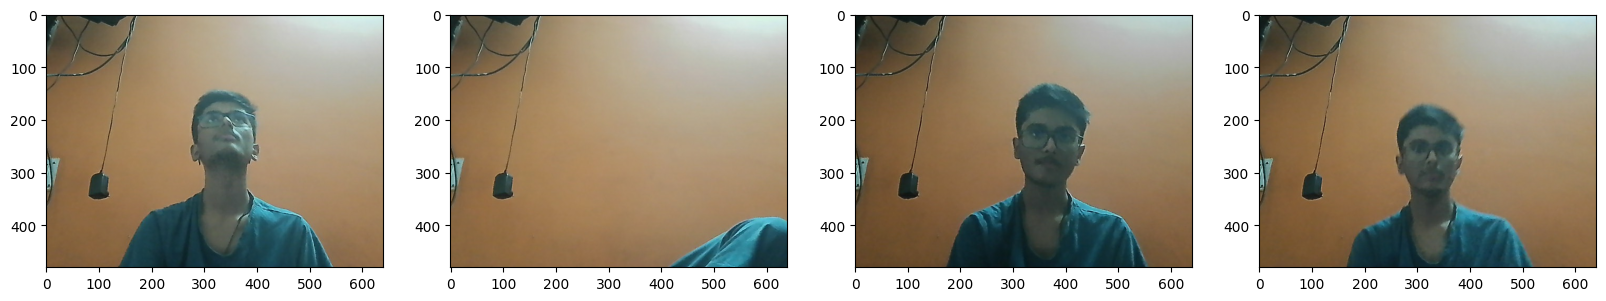

In [13]:

fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()


In [15]:
import os
import shutil
import random

# Base paths
base_dir = "data"
images_dir = os.path.join(base_dir, "images")
# labels_dir = os.path.join(base_dir, "labels")  # commented for now

# Output folders already exist (train/val/test with images & labels)
splits = ["train", "val", "test"]

# Collect all image files
image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
image_files.sort()  # ensure consistent order
random.shuffle(image_files)

# Split sizes
n = len(image_files)
train_size = int(0.7 * n)
val_size = int(0.15 * n)
test_size = n - train_size - val_size

train_files = image_files[:train_size]
val_files = image_files[train_size:train_size+val_size]
test_files = image_files[train_size+val_size:]

# Function to move/copy only images
def move_images(files, split):
    for file in files:
        src_img = os.path.join(images_dir, file)
        dst_img = os.path.join(base_dir, split, "images", file)

        if os.path.exists(src_img):
            shutil.copy(src_img, dst_img)   # use shutil.move to cut instead of copy


move_images(train_files, "train")
move_images(val_files, "val")
move_images(test_files, "test")

print(f"✅ Done! Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")


✅ Done! Train: 62, Val: 13, Test: 15


In [16]:
import os

# Go through train, val, test
for folder in ['train', 'val', 'test']:
    image_dir = os.path.join('data', folder, 'images')
    for file in os.listdir(image_dir):
        # Get matching label filename (.json)
        filename = file.split('.')[0] + '.json'

        # Where the label is currently stored
        existing_filepath = os.path.join('data', 'labels', filename)

        # Where the label should go
        new_filepath = os.path.join('data', folder, 'labels', filename)

        # Move only if label exists
        if os.path.exists(existing_filepath):
            os.replace(existing_filepath, new_filepath)

print("✅ Labels moved successfully into train/val/test folders")


✅ Labels moved successfully into train/val/test folders


IMAGE AUGMENTATIONS

In [17]:
import albumentations as alb

In [18]:
augmentor=alb.Compose([alb.RandomCrop(width=450,height=450),
                       alb.HorizontalFlip(p=0.5),
                       alb.RandomBrightnessContrast(p=0.2),
                       alb.RandomGamma(p=0.2),
                       alb.RGBShift(p=0.2),
                       alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams(format='albumentations',
                                                  label_fields=['class_labels']))

In [20]:
import cv2

img = cv2.imread(r"C:\Users\sahai\OneDrive\Desktop\DEEP-Learning\face_detection\data\train\images\ad87dc2e-7cff-11f0-9184-dc4ba1005df7.jpg")
img.shape

(480, 640, 3)

In [22]:
with open (os.path.join("data","train","labels","ad87dc2e-7cff-11f0-9184-dc4ba1005df7.json")) as f:
    label=json.load(f)

In [16]:
label

{'version': '5.8.3',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[113.05555555555554, 75.55555555555556],
    [359.1666666666667, 333.3333333333333]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {},
   'mask': None}],
 'imagePath': '..\\images\\00e043ef-7c06-11f0-9495-dc4ba1005df7.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYn

In [23]:
label['shapes']

[{'label': 'face',
  'points': [[327.5, 121.11111111111111],
   [533.6111111111111, 402.77777777777777]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {},
  'mask': None}]

In [24]:
tag=label['shapes'][0]['label']
tag

'face'

In [25]:
coordinates=label['shapes'][0]['points']
coordinates

[[327.5, 121.11111111111111], [533.6111111111111, 402.77777777777777]]

In [26]:
coords=[0,0,0,0]
coords[0]=coordinates[0][0]
coords[1]=coordinates[0][1]
coords[2]=coordinates[1][0]
coords[3]=coordinates[1][1]


In [27]:
coords

[327.5, 121.11111111111111, 533.6111111111111, 402.77777777777777]

In [28]:
coords = list(np.divide(coords, [640, 480, 640, 480]))#normalizing the coordinates for augmentation

In [29]:
coords

[np.float64(0.51171875),
 np.float64(0.2523148148148148),
 np.float64(0.833767361111111),
 np.float64(0.8391203703703703)]

In [30]:
augmented=augmentor(image=img,bboxes=[coords],class_labels=[tag])

In [31]:
augmented['image'].shape

(450, 450, 3)

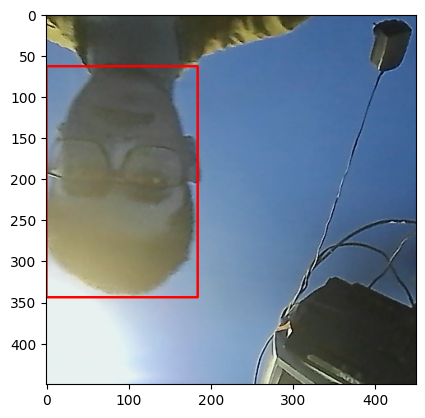

In [32]:
cv2.rectangle(
    augmented['image'],
    tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
    tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),
    (255, 0, 0), 2
)

plt.imshow(augmented['image'])

BUILD AUGMENTATION PIPELINE

In [33]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data',partition,'images')):
        img=cv2.imread(os.path.join('data',partition,'images',image))
        coords=[0,0,0.00001,0.00001]
        label_path=os.path.join('data',partition,'labels',f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path,'r')as f:
                label=json.load(f)
            coordinates=label['shapes'][0]['points']
            coords[0]=coordinates[0][0]
            coords[1]=coordinates[0][1]
            coords[2]=coordinates[1][0]
            coords[3]=coordinates[1][1]
            coords=list(np.divide(coords,[640,480,640,480]))
            
        try:
            for x in range(45):
                augmented=augmentor(image=img,bboxes=[coords],class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data',partition,'images',f'{image.split(".")[0]}.{x}.jpg'),augmented['image'])
                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0, 0, 0, 0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0, 0, 0, 0]
                    annotation['class'] = 0

                with open(os.path.join('aug_data', partition, 'labels', f"{image.split('.')[0]}-{x}.json"), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)



        

LOAD AUGMENTED IMAGES INTO TENSORFLOW

In [86]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x / 255)

test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x / 255)

val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x / 255)


LOADING THE IMAGE LABELS

In [164]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
    cls = np.array(label['class'], dtype=np.uint8)      # scalar integer
    bbox = np.array(label['bbox'], dtype=np.float32)    # [x, y, w, h]
    return cls, bbox


def set_shapes(cls, bbox):
    cls.set_shape([1])   # ek hi class
    bbox.set_shape([4])  # [x,y,w,h]
    return cls, bbox

# Train labels
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(
    load_labels, [x], [tf.uint8, tf.float32]
))
train_labels = train_labels.map(set_shapes)

# Test labels
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(
    load_labels, [x], [tf.uint8, tf.float32]
))
test_labels = test_labels.map(set_shapes)

# Validation labels
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(
    load_labels, [x], [tf.uint8, tf.float32]
))
val_labels = val_labels.map(set_shapes)


In [135]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.01246913, 0.14790124, 0.45444444, 0.78      ], dtype=float32))

COMBINE LABELS AND IMAGES

In [136]:
len(train_images),len(train_labels)

(2790, 2790)

In [97]:
len(test_images),len(test_labels)

(675, 675)

In [98]:
len(val_images),len(val_labels)

(585, 585)

CREATING FINAL DATASET

In [99]:
train=tf.data.Dataset.zip((train_images,train_labels))
train=train.shuffle(3000)
train=train.batch(8)
train=train.prefetch(4)

In [100]:
val=tf.data.Dataset.zip((val_images,val_labels))
val=val.shuffle(1000)
val=val.batch(8)
val=val.prefetch(4)

In [101]:
test=tf.data.Dataset.zip((test_images,test_labels))
test=test.shuffle(1000)
test=test.batch(8)
test=test.prefetch(4)

In [102]:
data_samples=train.as_numpy_iterator()
data_samples

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x000001BD79808C70>)

In [103]:
res=data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


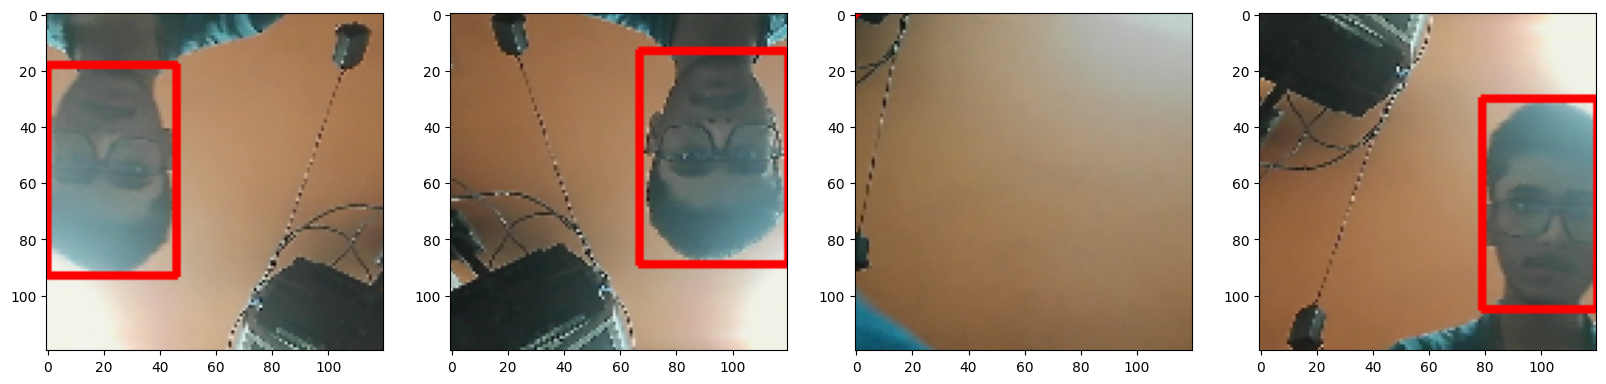

In [137]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = res[0][idx].copy()  
    sample_coords = res[1][1][idx]

    cv2.rectangle(
        sample_image,
        tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
        tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
        (255, 0, 0), 2
    )

    ax[idx].imshow(sample_image)

In [138]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,Dense,GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [139]:
vgg=VGG16(include_top=False)

In [140]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [141]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [142]:
facetracker = build_model()

In [143]:
facetracker.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │      2,049 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 4)         │      8,196 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [144]:
X, y = train.as_numpy_iterator().next()

In [145]:
X.shape

(8, 120, 120, 3)

In [146]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


In [147]:
classes, coords

(array([[0.35961592],
        [0.38494363],
        [0.4208845 ],
        [0.36232612],
        [0.35243252],
        [0.39722648],
        [0.3333858 ],
        [0.3646786 ]], dtype=float32),
 array([[0.677211  , 0.613183  , 0.62001705, 0.52070975],
        [0.67854774, 0.64005524, 0.5461905 , 0.5211541 ],
        [0.6397147 , 0.6834857 , 0.5937307 , 0.51306945],
        [0.5953032 , 0.6080053 , 0.62594295, 0.5296382 ],
        [0.6836026 , 0.6115842 , 0.5390321 , 0.5554135 ],
        [0.68707806, 0.7119578 , 0.6303897 , 0.5966457 ],
        [0.697926  , 0.5722132 , 0.5721358 , 0.53579354],
        [0.6945976 , 0.689243  , 0.5721503 , 0.58364797]], dtype=float32))

BUILDING CUSTOMIZE LOSS FUNCTION FOR CLASSIFICATION AND LOCALISATION MODEL

In [148]:
batches_per_epoch=len(train) #specifying learning rate decay

lr_decay=(1./0.75-1)/batches_per_epoch
lr_decay

0.0009551098376313274

In [149]:
opt=tf.keras.optimizers.Adam(learning_rate=0.0001,weight_decay=lr_decay)

In [150]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [151]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [152]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.535869598388672>

In [153]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9914153814315796>

In [155]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.535869598388672>

CUSTOM TRAINING LOSS MODEL

In [165]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(
                tf.cast(tf.reshape(y[0], [-1]), tf.int32), classes
            )
            batch_localizationloss = self.lloss(
                tf.cast(tf.reshape(y[1], [-1, 4]), tf.float32), coords
            )
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(
            tf.cast(tf.reshape(y[0], [-1]), tf.int32), classes
        )
        batch_localizationloss = self.lloss(
            tf.cast(tf.reshape(y[1], [-1, 4]), tf.float32), coords
        )
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [166]:
model = FaceTracker(facetracker)

In [167]:
model.compile(opt, classloss, regressloss)

TRAIN

In [161]:
logdir='logs'

In [162]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [81]:
# def preprocess_function(image, label):
#     image = tf.cast(image, tf.float32) / 255.0
#     class_label = tf.cast(label[0], tf.float32)
#     coords = tf.cast(label[1], tf.float32)
#     return image, (class_label, coords)

# train = train.map(preprocess_function)
# train = train.batch(32)

# val = val.map(preprocess_function) 
# val = val.batch(32)

In [169]:
hist = model.fit(train, epochs=3, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/3


349/349 ━━━━━━━━━━━━━━━━━━━━ 425s 1s/step - class_loss: 2.4451e-05 - regress_loss: 0.0140 - total_loss: 0.0140 - val_class_loss: 5.3070e-05 - val_regress_loss: 3.6663e-05 - val_total_loss: 6.3198e-05
Epoch 2/3
349/349 ━━━━━━━━━━━━━━━━━━━━ 346s 986ms/step - class_loss: 3.1150e-05 - regress_loss: 0.0032 - total_loss: 0.0032 - val_class_loss: 3.6728e-05 - val_regress_loss: 6.7957e-04 - val_total_loss: 6.9793e-04
Epoch 3/3
349/349 ━━━━━━━━━━━━━━━━━━━━ 368s 1s/step - class_loss: 2.2561e-05 - regress_loss: 0.0049 - total_loss: 0.0049 - val_class_loss: 7.2517e-06 - val_regress_loss: 0.0041 - val_total_loss: 0.0041


PLOT PERFORMANCE

In [170]:
hist.history

{'class_loss': [2.445053542032838e-05,
  3.115049912594259e-05,
  2.25607927859528e-05],
 'regress_loss': [0.013959955424070358,
  0.00321042537689209,
  0.0049355523660779],
 'total_loss': [0.013972180895507336,
  0.0032260005827993155,
  0.004946832545101643],
 'val_class_loss': [5.30698562215548e-05,
  3.672777893370949e-05,
  7.251655461004702e-06],
 'val_regress_loss': [3.6662760976469144e-05,
  0.0006795654771849513,
  0.004056394100189209],
 'val_total_loss': [6.319768726825714e-05,
  0.0006979293539188802,
  0.004060019738972187]}

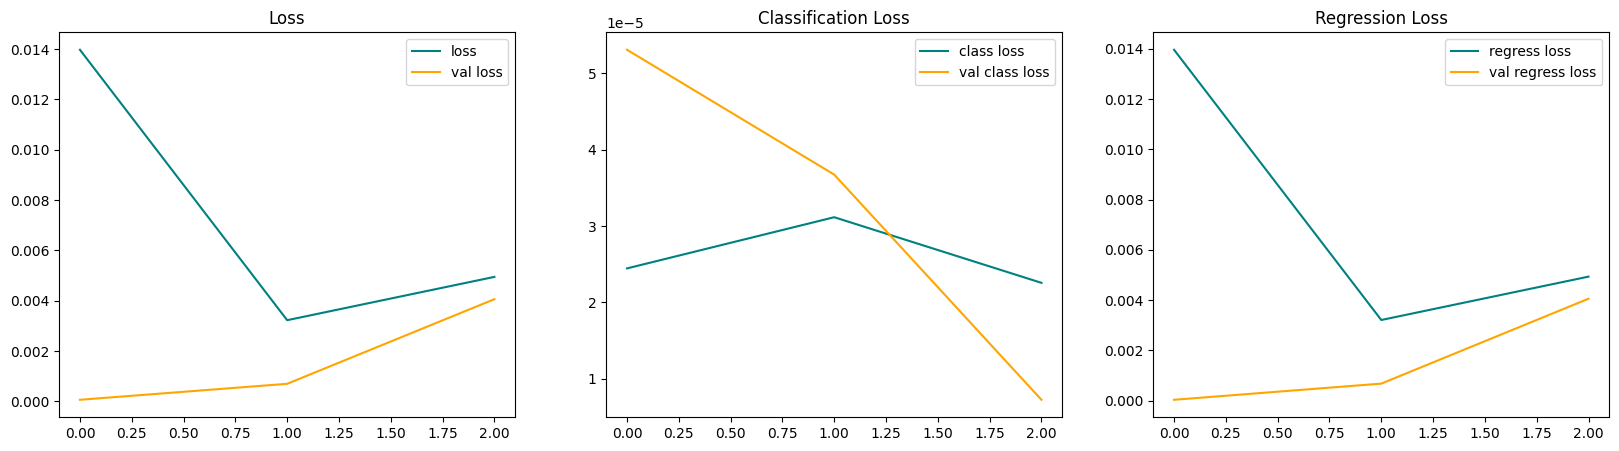

In [171]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

PREDICTIONS

In [172]:
test_data = test.as_numpy_iterator()

In [178]:
test_sample = test_data.next()

In [179]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


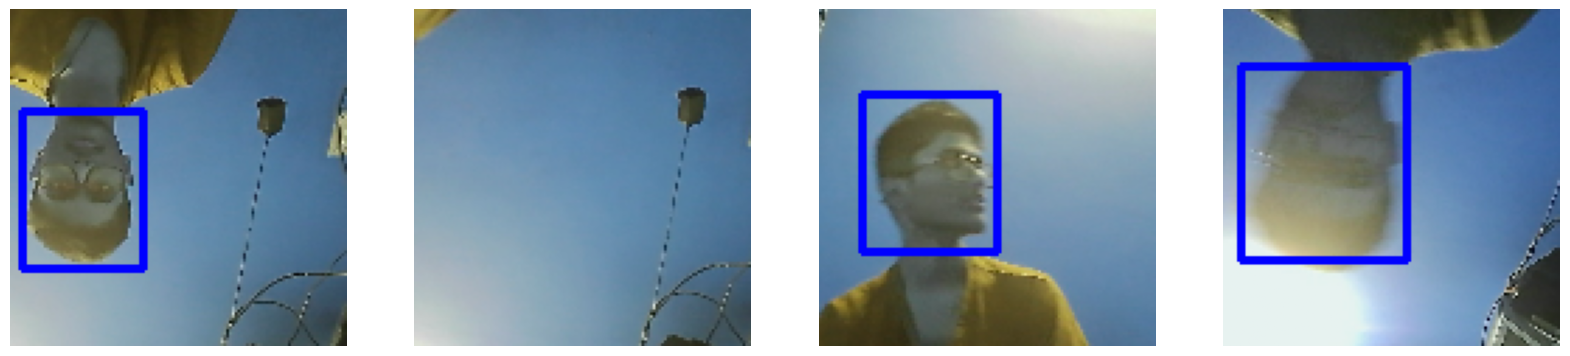

In [180]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx in range(4): 
    sample_image = test_sample[0][idx].copy()   # copy banaya, taaki writable ho jaye
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9: #checking confidencce score
        cv2.rectangle(
            sample_image,
            tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
            tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
            (255, 0, 0), 2
        )
    
    # OpenCV BGR -> Matplotlib RGB
    ax[idx].imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
    ax[idx].axis("off")


SAVE THE MODEL

In [181]:
from tensorflow.keras.models import load_model

In [182]:
facetracker.save('facetracker.h5')

In [183]:

facetracker = load_model('facetracker.h5')

REAL TIME DETECTION


In [185]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━